# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Mon, Mar 07, 5:00pm

**Late Penalty**:  Any work that is submitted between 0 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Shiva Akbari <shiva.akbari@mail.utoronto.ca>

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/11OSIdxpmHhPn2sr0r2dZsQ2xTEU5MrBw

In [1]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import matplotlib.pyplot as plt

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [2]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [3]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

/Users/frank.c/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


In [45]:
df.shape # 32561 rows, and 14 columns (attribute)

(32561, 11)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [5]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [6]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]] #/ choose specific columns
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [7]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [8]:
''' Answer: Report the minimum, maximum, and average value across the dataset.'''

# Before normalization
subdf.describe(percentiles=[.25, .5, .75]) #/ get some statistic of the data before the manipulation
# Param {percentiles} : default percentile = [.25, .5, .75] 
# Param {exclude} {include} {datetime_is_numeric}

,age,yredu,capgain,caploss,workhr
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,40.437456
std,13.640433,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [9]:
''' Answer: normalize each of the features ["age", "yredu", "capgain", "caploss", "workhr"] so that their values are always between 0 and 1 '''
col_to_nomalize = ["age", "yredu", "capgain", "caploss", "workhr"]

#/ How to normalize: (val - min) / (max - min)

for i in range(len(col_to_nomalize)):
    col = df[col_to_nomalize[i]] #/ col is a vector
    col_range = col.max() - col.min()
    df[col_to_nomalize[i]] = (col - col.min()) / col_range

df.describe()

,age,fnlwgt,yredu,capgain,caploss,workhr
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,0.295639,1.897784e+05,0.605379,0.010777,0.020042,0.402423
std,0.186855,1.055500e+05,0.171515,0.073854,0.092507,0.125994
min,0.000000,1.228500e+04,0.000000,0.000000,0.000000,0.000000
25%,0.150685,1.178270e+05,0.533333,0.000000,0.000000,0.397959
50%,0.273973,1.783560e+05,0.600000,0.000000,0.000000,0.397959
75%,0.424658,2.370510e+05,0.733333,0.000000,0.000000,0.448980
max,1.000000,1.484705e+06,1.000000,1.000000,1.000000,1.000000


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [10]:
''' Answer: percentage of male and female'''
# hint: you can do something like this in pandas
num_male = sum(df["sex"] == " Male")
num_female = sum(df["sex"] == " Female")

print("Percentage of male: {}".format(round(100* num_male/len(df["sex"]),1)))
print("Percentage of female: {}".format(round(100* num_female/len(df["sex"]),1)))

Percentage of male: 66.9
Percentage of female: 33.1


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [11]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"] #/ attributes that need one-hot encoding
features = contcols + catcols #/ extract feature with attributes from contcols and catcols
df = df[features] #/ Extracted all attributes actually, filter out value with NaN in the following block

In [46]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

''' Answer: number and percentage of record that contained missing features'''
print("Number of record that contained missing features: {}".format(len(df_with_missing)))
print("Percentage of record that contained missing features: {}".format(round(100 * len(df_with_missing) / df.shape[0], 1)))


Number of record that contained missing features: 1843
Percentage of record that contained missing features: 5.7


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [13]:
''' Answer: possible values for attribute 'work' '''
df_not_missing['work'].value_counts()
# df_not_missing['work'].unique() or set(df_not_missing["work"]) provide only get the values, not the counts

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
Name: work, dtype: int64

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [14]:
data = pd.get_dummies(df_not_missing) #/ produce one-hot encodings for all of the categorical variables

In [15]:

## Print the one-hot encoding for work in data
data_features = data.keys()
data_features_with_work = [value for value in data_features if 'work' in value.lower()]
for i in range(len(data_features_with_work)):
    print(data_features_with_work[i])

workhr
work_ Federal-gov
work_ Local-gov
work_ Private
work_ Self-emp-inc
work_ Self-emp-not-inc
work_ State-gov
work_ Without-pay


In [16]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [17]:
''' Answer: Number of columns in the dataframe data'''
print('Number of columns: ', data.shape[1])

Number of columns:  57


### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [18]:
print("original types: ")
for i in range(len(data.values[0])):
    print(type(data.values[0][i]), end=" ")

original types: 
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>

In [19]:
datanp = data.values.astype(np.float32) #/ convert from numpy.float64 to numpy.float32
print(type(datanp[0][0]))

<class 'numpy.float32'>


In [20]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()): #/ attributes of data
    if "_" in header: # categorical header
        feature, value = header.split() #/ default value for delimeter is space " "
        # Example: 'work_ Federal-gov' will be split into 'work_" and "Federal-gov"
        feature = feature[:-1] # remove the last char; it is always an underscore
        # Example: 'work_' will be cut to 'work'
        if feature not in cat_index:
            cat_index[feature] = i
            # Example: {'work': 5}
            cat_values[feature] = [value]
            # Example: {'work': ['Federal-gov']}
        else:
            cat_values[feature].append(value)
            # Example: {'work': ['Federal-gov', 'Local-gov']}


# Description: Return the portion of `record` that is the one-hot encoding of `feature`. For example, since the feature "work" is stored in the indices[5:12] in each record, calling `get_range(record, "work") is equivalent to accessing `record[5:12]`.
def get_onehot(record, feature):
    # Param1 {record} : a numpy array representing one record, formatted the same way as a row in `data.np
    # Param2 {feature} : a string, should be an element of `catcols`

    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]


def get_categorical_value(onehot, feature):
    # Description: Return the categorical value name of a feature given a one-hot vector representing the feature.
    # Param1 {onehot} : a numpy array one-hot representation of the feature, only contains the attribute of this feature
    # Param2 {feature} : a string, should be an element of `catcols`

    # Examples:
    # >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work"
    # 'State-gov'
    # >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    # 'Private'
    
    #/ only turn the maximum value to 1, and disregard the other ones, setting to 0
    #/ The normalized input will comes from the last activation of training

    ''' Answer: implementation of get_categorical_value'''
    return cat_values[feature][np.argmax(onehot)]

In [21]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    # Description: Return the categorical feature value of a record
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature) #/ get the one-hot encoding and feed to get_categorical_value to get largest index

def get_features(record):
    # Description: Return a dictionary of all categorical feature values of a record
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [22]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

''' Answer: split data into approximately 70% training, 15% validation and 15% test'''

divider1 = round(len(data) * 0.7)
divider2 = round(len(data) * (0.7 + 0.15))
train_data = datanp[: divider1]
val_data = datanp[divider1 : divider2]
test_data = datanp[divider2: ] # test_data = datanp[divider2: -1] will exclude the last one, incorrect

''' Answer: Repor the number of your training, validation and test data'''
print("Number of traing data: {}".format(len(train_data)))
print("Number of validation data: {}".format(len(val_data)))
print("Number of test data: {}".format(len(test_data)))
print("Number of rows in datanp: {}".format(len(train_data) + len(val_data) + len(test_data)))

Number of traing data: 21503
Number of validation data: 4607
Number of test data: 4608
Number of rows in datanp: 30718


# Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [23]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        self.name = "AutoEncoder"
        super(AutoEncoder, self).__init__()
        ''' Answer: Architecture of the model'''
        self.encoder = nn.Sequential(
            nn.Linear(57, 57),
            nn.ReLU(),
            nn.Linear(57, 40),
            nn.ReLU(),
            nn.Linear(40, 20)
        )
        #/ 3layers; embedding of size 20
        self.decoder = nn.Sequential(
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 57),
            nn.ReLU(),
            nn.Linear(57, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

In [24]:
''' Answer: Why there is a sigmoid function '''
# That is because our final layer from the model should be a one-hot encoding that will feed into the function get_categorical_value().
# The function get_categorical_value(), as we defined above, receive normalized one-hot encoding from 0 to 1. Thus, we must normalize the value using a sigmoid function as the final activation function of the model.
# We could use the max value between 0 and 1 to predict the output.

' Answer: Why there is a sigmoid function '

# Part 3. Training [18 pt] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [25]:
def zero_out_feature(records, feature):
    # Description: Set the feature missing in records, by setting the appropriate columns of records to 0
    #/ Idea: Randomly zero out inputs using dropout to force the autoencoder to learn useful features
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    # Description: Set one random feature missing in records, by setting the appropriate columns of records to 0
    return zero_out_feature(records, random.choice(catcols))

In [26]:
def data_loader(bs=64, _shuffle=True):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=_shuffle)
    valid_loader = torch.utils.data.DataLoader(val_data, batch_size=bs, shuffle=_shuffle)
    return train_loader, valid_loader

In [27]:
def train(model, num_epochs=5, learning_rate=1e-4, batch_size=64, plot=True):
    ## Load data
    train_loader, valid_loader = data_loader(bs=batch_size)

    ## Initialize list
    iters, train_losses, val_losses, train_accs, val_accs = ([] for i in range(5))

    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    print("num_epoch       train_loss       val_loss       train_acc       val_acc") # table header

    ## Training
    for epoch in range(num_epochs):
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            train_loss = criterion(recon, data)
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        ''' Answer: Training'''
        #$ Validation
        for data in valid_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            val_loss = criterion(recon, data)

        #$ Record values
        train_acc = get_accuracy(model, train_loader)
        val_acc = get_accuracy(model, valid_loader)

        iters.append(epoch + 1)
        train_losses.append(float(train_loss))
        val_losses.append(float(val_loss))
        train_accs.append(get_accuracy(model, train_loader))
        val_accs.append(get_accuracy(model, valid_loader))

        #$ Print statistics
        # use '_' as filler because in some font ' ' doesn't take the same space as a character, so there could be mismatch that is hard to solve
        print("{0:_^9}       {1:_^10.2f}       {2:_^8.2f}       {3:_^9.2f}       {4:_^7.2f}".format(str(epoch + 1), train_loss, val_loss, train_acc, val_acc))

        #$ Save model data and statistics
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch + 1)
        torch.save(model.state_dict(), "./data/Lab4/" + model_path)

    ## plotting
    if plot:
        plt.title("Loss Curve")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.plot(iters, train_losses, label="Train")
        plt.plot(iters, val_losses, label="Validation")
        plt.show()
    else:
        print("--------------------------------------------------------------")

    print("Final round Traing Loss: {}".format(train_losses[-1]))
    print("Final round Validation Loss: {}".format(val_losses[-1]))

    if plot:
        plt.title("Accuracy Curve")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.plot(iters, train_accs, label="Train")
        plt.plot(iters, val_accs, label="Validation")
        plt.legend(loc='best')
        plt.show()

    print("Final round Traing Accuracy: {}".format(train_accs[-1]))
    print("Final round Validation Accuracy: {}".format(val_accs[-1]))

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [28]:
def get_accuracy(model, data_loader):
    # Description: Return the "accuracy" of the autoencoder model across a data set. That is, for each record and for each categorical feature, we determine whether the model can successfully predict the value of the categorical feature given all the other features of the record. The returned "accuracy" measure is the percentage of times that our model is successful.
    
    # Param1 {model} : the autoencoder model, an instance of nn.Module
    # Param2 {data_loader} : an instance of torch.utils.data.DataLoader

    # Example (to illustrate how get_accuracy is intended to be called. Depending on your variable naming this code might require modification.)
    # >>> model = AutoEncoder()
    # >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
    # >>> get_accuracy(model, vdl)

    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy() #/ produce test result
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

num_epoch       train_loss       val_loss       train_acc       val_acc
____1____       ___0.07___       __0.07__       __0.44___       _0.44__
____2____       ___0.07___       __0.07__       __0.45___       _0.45__
____3____       ___0.07___       __0.07__       __0.46___       _0.46__
____4____       ___0.05___       __0.06__       __0.53___       _0.52__
____5____       ___0.06___       __0.06__       __0.55___       _0.55__


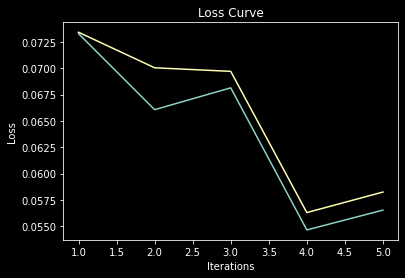

Final round Traing Loss: 0.056532908231019974
Final round Validation Loss: 0.058247484266757965


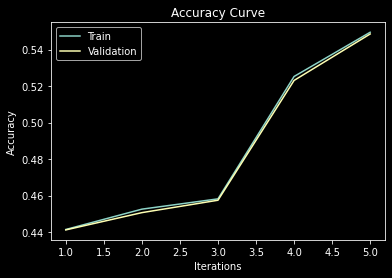

Final round Traing Accuracy: 0.5495434745539383
Final round Validation Accuracy: 0.5485854858548586


In [29]:
''' Answer: Train '''
model = AutoEncoder()
train(model) # use default hyperparameters
# num_epochs = 5, learning_rate = 1e-4, batch_size = 64

#Final round Traing Loss: 0.05527644604444504 
#Final round Validation Loss: 0.06122467294335365
#Final round Traing Accuracy: 0.5358089568897363
#Final round Validation Accuracy: 0.5322335576296939

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

In [30]:
''' Answer: Tune the hyperparameters'''
# The hyperparameters in this case are ① Number of epoches ② Batch size, and ③ Learning rate
# I will investigate each of them

' Answer: Tune the hyperparameters'

In [31]:
''' Answer: 1. Increase number of epoches''' 
model = AutoEncoder()
train(model, num_epochs=20, plot=False)

#Final round Traing Loss: 0.033555589616298676
#Final round Validation Loss: 0.0363919697701931
#Final round Traing Accuracy: 0.5904369932877583
#Final round Validation Accuracy: 0.590044135735475

# Since this model works much better than only 5 epoches, later hyperparameters search will use num_epochs = 20

num_epoch       train_loss       val_loss       train_acc       val_acc
____1____       ___0.07___       __0.07__       __0.45___       _0.45__
____2____       ___0.07___       __0.07__       __0.46___       _0.46__
____3____       ___0.07___       __0.07__       __0.46___       _0.46__
____4____       ___0.06___       __0.06__       __0.46___       _0.46__
____5____       ___0.06___       __0.06__       __0.54___       _0.54__
____6____       ___0.05___       __0.05__       __0.56___       _0.56__
____7____       ___0.06___       __0.06__       __0.57___       _0.57__
____8____       ___0.05___       __0.05__       __0.57___       _0.57__
____9____       ___0.05___       __0.05__       __0.57___       _0.57__
___10____       ___0.04___       __0.04__       __0.57___       _0.57__
___11____       ___0.04___       __0.05__       __0.57___       _0.57__
___12____       ___0.05___       __0.05__       __0.57___       _0.57__
___13____       ___0.04___       __0.05__       __0.57___       

In [32]:
''' Answer: 2. Increase training rate'''
model = AutoEncoder()
train(model, num_epochs=20, learning_rate=1e-3, plot=False)

#Final round Traing Loss: 0.014145386405289173
#Final round Validation Loss: 0.01599755510687828
#Final round Traing Accuracy: 0.6250213148552916
#Final round Validation Accuracy: 0.6219521018739599

# Since this model with lr=1e-3 work much better than lr=1e-4, later hyperparameters search will use lr=1e-3

num_epoch       train_loss       val_loss       train_acc       val_acc
____1____       ___0.06___       __0.05__       __0.57___       _0.57__
____2____       ___0.04___       __0.04__       __0.58___       _0.58__
____3____       ___0.04___       __0.04__       __0.60___       _0.60__
____4____       ___0.03___       __0.03__       __0.60___       _0.60__
____5____       ___0.03___       __0.03__       __0.60___       _0.60__
____6____       ___0.03___       __0.03__       __0.61___       _0.61__
____7____       ___0.03___       __0.04__       __0.60___       _0.60__
____8____       ___0.02___       __0.03__       __0.61___       _0.61__
____9____       ___0.03___       __0.03__       __0.61___       _0.61__
___10____       ___0.02___       __0.02__       __0.61___       _0.61__
___11____       ___0.02___       __0.02__       __0.61___       _0.61__
___12____       ___0.03___       __0.02__       __0.61___       _0.61__
___13____       ___0.02___       __0.02__       __0.62___       

In [33]:
''' Answer: 3. Increase batch size'''
model = AutoEncoder()
train(model, num_epochs=20, batch_size=128, learning_rate=1e-3, plot=False)

#Final round Traing Loss: 0.016742540523409843
#Final round Validation Loss: 0.022027965635061264
#Final round Traing Accuracy: 0.6142863786448403
#Final round Validation Accuracy: 0.6120396498082628

# Since this model with bs=128 did outperform than the previous set of parameters with bs=64, we discard this set of parameters. Later I will discover whether decrease the batch size will lead to better accuracy and loss

num_epoch       train_loss       val_loss       train_acc       val_acc
____1____       ___0.06___       __0.06__       __0.48___       _0.48__
____2____       ___0.05___       __0.06__       __0.57___       _0.57__
____3____       ___0.05___       __0.05__       __0.58___       _0.58__
____4____       ___0.04___       __0.04__       __0.58___       _0.58__
____5____       ___0.04___       __0.04__       __0.59___       _0.59__
____6____       ___0.03___       __0.04__       __0.60___       _0.60__
____7____       ___0.03___       __0.04__       __0.61___       _0.61__
____8____       ___0.03___       __0.03__       __0.61___       _0.61__
____9____       ___0.03___       __0.03__       __0.62___       _0.62__
___10____       ___0.03___       __0.03__       __0.62___       _0.62__
___11____       ___0.02___       __0.03__       __0.62___       _0.62__
___12____       ___0.03___       __0.03__       __0.63___       _0.62__
___13____       ___0.02___       __0.03__       __0.62___       

In [34]:
''' Answer: 4. Decrease batch size'''
model = AutoEncoder()
train(model, num_epochs=20, batch_size=32, learning_rate=1e-3, plot=False)

#Final round Traing Loss: 0.017107781022787094
#Final round Validation Loss: 0.009987073950469494
#Final round Traing Accuracy: 0.6558387201785797
#Final round Validation Accuracy: 0.6512553360827726

# Best accuracy and loss found so far with hyperparameters ① num_epochs=20, ② batch_size=32 and ③ learning_rate=1e-3

num_epoch       train_loss       val_loss       train_acc       val_acc
____1____       ___0.05___       __0.04__       __0.58___       _0.58__
____2____       ___0.03___       __0.04__       __0.60___       _0.60__
____3____       ___0.03___       __0.03__       __0.60___       _0.60__
____4____       ___0.02___       __0.02__       __0.59___       _0.59__
____5____       ___0.02___       __0.03__       __0.61___       _0.61__
____6____       ___0.02___       __0.03__       __0.61___       _0.61__
____7____       ___0.02___       __0.02__       __0.61___       _0.61__
____8____       ___0.02___       __0.02__       __0.61___       _0.61__
____9____       ___0.02___       __0.01__       __0.61___       _0.61__
___10____       ___0.02___       __0.02__       __0.61___       _0.61__
___11____       ___0.01___       __0.03__       __0.62___       _0.62__
___12____       ___0.02___       __0.02__       __0.62___       _0.62__
___13____       ___0.02___       __0.01__       __0.63___       

In [35]:
''' Answer: Effect of each hyperparameters'''
# Increased number of epochs simply train the network for a longer time, thus will result in better performance given the model is not overfitting.
# Increasing learning rate make faster convergence to better solution . In my tuning above, lr=1e-3 is a moderate learning rate.
# Larger batch size allow more training data to be assessed every iteration and and smaller batch size will update the parameters more frequently. In my tuning above, bs=32 is a moderate batch size.

' Answer: Effect of each hyperparameters'

# Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [36]:
''' Answer: Test Accuracy'''
# I found the best set of hyperparemters from the 4th try from last part, I will use this model for the test accuracy

model_path = "./data/Lab4/" + "model_{0}_bs{1}_lr{2}_epoch{3}".format("AutoEncoder", 32, 0.001, 20)
state = torch.load(model_path) # load from the best model found so far

encoder = AutoEncoder()
encoder.load_state_dict(state)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)
test_acc = round(get_accuracy(encoder, test_loader) * 100, 2)

print("Test accuracy is {}%".format(test_acc))

Test accuracy is 63.11%


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [37]:
''' Answer: Test accuracy for attribute 'marriage' '''
col_max = {}  # The baselinemodel prediction: get the most frequent value from each column

print("Most frequent attribute:")
print("--------------------------------------------------------------")
for i in df_not_missing.columns: # choose the dataset df_not_missing so that the count of each column is the same
    col_max[i] = df_not_missing[i].value_counts().idxmax() # find the most frequent one
    print("{0}:\t\t{1}".format(i, col_max[i]))
print("--------------------------------------------------------------")

accuracy = sum(df_not_missing['marriage'] == col_max['marriage']) / len(df_not_missing)
print("Accuracy for baseline model for attribute 'marriage' is {}%".format(round(accuracy * 100, 2)))

Most frequent attribute:
--------------------------------------------------------------
age:		0.2602739726027397
yredu:		0.5333333333333333
capgain:		0.0
caploss:		0.0
workhr:		0.3979591836734694
work:		 Private
marriage:		 Married-civ-spouse
occupation:		 Prof-specialty
edu:		 HS-grad
relationship:		 Husband
sex:		 Male
--------------------------------------------------------------
Accuracy for baseline model for attribute 'marriage' is 46.68%


In [38]:
''' Answer: Overall accuracy of all attributes'''
acc = []
for i in df_not_missing.columns:
    accuracy = sum(df_not_missing[i] == col_max[i]) / len(df_not_missing)
    acc.append(accuracy)
    
print("Average accuracy for baseline model for all attribute 'marriage' is {}%".format(round(np.mean(acc) * 100, 2)))

Average accuracy for baseline model for all attribute 'marriage' is 49.54%


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

In [39]:
# Average baseline accuracy is 49.54% from last part. 
# My model from part 4(a) has accuracy 63.78%, which is much better than the baseline model

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [40]:
pd.DataFrame(columns=data.columns, data=[test_data[0]])

# I would say that it's not reasonable for a human to guess a person's education level based on their other features.
# There are not much correlations between education level and work, gender, marriage, capgain, etc.

# Thus, my model only predict at 64% accuracy at last, not very high.

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.369863,0.8,0.0,0.0,0.44898,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [41]:
print("edu features:")
edu_features = [value for value in data_features if 'edu' in value.lower()]
data[edu_features][0:1]

edu features:


,yredu,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college
0,0.8,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [42]:
test_loader = torch.utils.data.DataLoader(test_data[0:1]) # only need the first one

for item in test_loader:
    int = item.detach().numpy()
    out = encoder(zero_out_feature(item.clone(), "edu")).detach().numpy()
    print(get_feature(out[0], "edu"))

Bachelors


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [43]:
print(col_max['edu'])
# Expected output of the baseline model would by HS-grad

 HS-grad
